# A Convolutional Neural Network project identifying ships around a harbor
Written by Lucia Cani

## 1.introduction

The goal of this project is to learn and try out different techniques used in computer vision, specifically building, and deploying a CNN model. This will be a beginner friendly project that will focus on EDA, preprocessing techniques, and the evaluation of models. 

The plan is to create an image classification model using Convolutions for feature extraction. Then to pass through a Region Proposal Network(RPN) to create a faster R-CNN model for object detection using TensorFlow as a framework. 

**A Convolutional Neural Network**, also known as CNN, is a class of neural networks that specializes in processing data that has a grid-like topology, such as an image. A digital image is a binary representation of visual data. CNN can recognize patterns and features in images by performing convolution and pooling operations on the input images to extract relevant information. 
**Region-based CNNs** or regions with CNN features (R-CNNs) are also among many pioneering approaches of applying deep learning to object detection.To reduce region proposals without loss of accuracy, the faster R-CNN proposes to replace selective search with a region proposal network

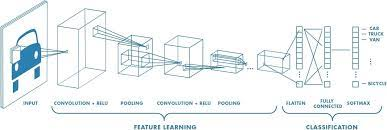 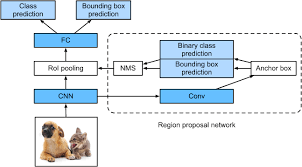

**Summery of data set**

[The Dataset](https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery)

The dataset consists of images extracted from Planet satellite imagery collected over the San Francisco Bay and San Pedro Bay areas of California. The aim of this dataset is to help address the difficult task of detecting the location of large ships in satellite images. Automating this process can be applied to many issues including monitoring port activity levels and supply chain analysis.

The dataset consists of 4000 80x80 RGB images labeled with either a "ship" or "no-ship" The pixel value data for each 80x80 RGB image is stored as a list of 19200 integers within the data list. The first 6400 entries contain the red channel values, the next 6400 the green, and the final 6400 the blue. The image is stored in row-major order so that the first 80 entries of the array are the red channel values of the first row of the image.


## 2. Setup and laoding the data

#### 2.1 Importing moduels and setup

 The definition of a module is "a distinct assembly of components that can be easily added, removed or replaced in a larger system". In Python, Modules are simply a code library or a file that contain a set of functions that you want to include in your application.We import modules that help us with our project. these can be written by others or yourself and are later used so that you don’t have to rewrite code or write code from scratch.

In [ ]:
# importing some not all nessesery modules, for now.
import pandas as pd #to work with data 
import numpy as np # to help with matrix calculations
import tensorflow as tf # to assemble and work with mechine learning modules

import os # to work with directories
import matplotlib.pyplot as plt # for plotting data
import seaborn as sns # for plotting data
import cv2 # to work with images
from PIL import Image
import json # to work with json files
import sklearn #for doing machine learning computation      

In [ ]:
!pip list #looking at installed modules

#### 2.1.2 Enableing the GPU and restricting memory use on the device

This is specific to my device and are optinal for you to run, if you have not done the necessary installations follow links below. Only when working with tensorflow.
- https://www.tensorflow.org/install/source_windows
- https://learn.microsoft.com/en-us/windows/ai/directml/gpu-tensorflow-wsl

In [ ]:
# looking for the GPU on the device and how many they are
physical_devices = tf.config.list_physical_devices('GPU')
print(len(physical_devices))#if 0 then the computation is done on CPU
    

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/config/experimental/get_memory_growth
# Avoids OOM errors
if physical_devices is not None:
    for gpu in physical_devices:
        tf.config.experimental.set_memory_growth(gpu,True)
else:
    print('No active GPU')

#### 2.2 Load Data

There are diffirent options here,pandas, python read file or tensorflows.data.dataset. I'm choosing a tensorflow dataset and will be using the keras "image_dataset_from_directory" its a good image input pipeline tool that will return a `tf.data.Dataset` and yields batches of images from the subdirectories `class_a` and `class_b`, together with labels 0 and 1 (0 corresponding to `class_a` and 1 corresponding to `class_b`). 
[resource link](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory#used-in-the-notebooks_1)

In [ ]:
# looking at what we are working with
data_dir = 
os.listdir(data_dir) # we have a json file we can work with, or directorys

In [ ]:
os.listdir('Data/ships') # the directories have sub dirs,split into the classes represented. 
path = os.path.join('Data','ships') # we'll use this path for our input pipline

In [ ]:
# inporting image data in to a tensorflow dataset
dataset = tf.keras.utils.image_dataset_from_directory(path,image_size= (80, 80), batch_size=25, seed = 42)#answer to life

In [ ]:
#Returns an iterator which converts all elements of the dataset to numpy. 
data_itirator = dataset.as_numpy_iterator()
batch = data_itirator.next() # extracting one batch from the dataset.

In [ ]:
print('images:',batch[0].shape,'\n',# the batch first column has 32 units that are 80 x 80 in size and has 3 dimentions
'labels:',batch[1].shape) # this is the lables, also 32 elements

In [ ]:
#spliting the dataset into x and y and saiving them to an np.array. doing this so that calculations can be made with the values later
x = np.array([])
y = np.array([])
for img, lable in dataset.as_numpy_iterator():
    x = np.append(x,img)
    y =np.append(y,lable)

print('image shape:',x.shape,'lable shape:',y.shape) 

In [ ]:
# needs reshaping
x = x.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
y = y.reshape([-1, 1])
print('New shape:',x.shape , '\nNew shape:',y.shape)

##### Obs! reading in the data throuh the json file is just for demonstration as an alternetiv, will not work with rest of notebook


In [ ]:
with open('../Cumputor-vision/Data/shipsnet.json') as file:
    dset = json.load(file)
df = pd.DataFrame(dset)

In [ ]:
df.head()

In [ ]:
df.info()

In [ ]:
# Turning the json information into numpy array and then assign it as x and y variables
#borde göra en ny df. med dessa värden
image = np.array(dset['data']).astype('uint8')
label = np.array(dset['labels']).astype('uint8')

In [ ]:
print('image shape:',image.shape,
'lable shape:',label.shape)

In [ ]:
x_reshaped = image.reshape([-1, 3, 80, 80]).transpose([0,2,3,1])
y_reshaped = label.reshape([-1, 1])
print('New shape:',x_reshaped.shape , '\nNew shape:',y_reshaped.shape)

## 3. EDA Underatanding the data

When it comes to EDA for image classification, the exploratory analysis is limited. Instead of the usual steps taken during the EDA prosses, here we will focus on what will affect the overall model performance. What do we need to know to make sure our CNN will perform as well as possible? there are 3 main things we could do here. 
 - Identifying Class Imbalance.  Imbalance in a CNN could result in poor performance for the class with less representation, impacting overall performance.
 - Plotting Image Size. Consistent image size is crucial for deep learning, mismatched matrices will stop the computation.
 - Viewing a Sampling of Images, although this is not always a necessary part for the model performance. it familiarizes you with the data and help you identify bad images. Like an image that is to dark or to bright. 


#### 3.1.Identifying Class Imbalance 

In [ ]:
# making a dictionary holding the size info of the image directories
classes = {'no_ship': len(os.listdir('Data/ships/no_ship')),
'ship': len(os.listdir('Data/ships/ship'))
}

In [ ]:
# plotting a histogram based on the information from the cell above.
plt.bar(classes.keys(), classes.values(), width = .5, color = ['cadetblue','royalblue']);
plt.title("Number of Images per Class");
plt.xlabel('Class Name');
plt.ylabel('Number of Images');

This shows a clear inbalance between the ship vs no ship class, the no ship class is 3/4 the size of the ship class

In [ ]:
# pie plot will give us a better understanding of the representaion 
plt.pie(classes.values(),
       labels=classes.keys(),
       autopct="%1.1f%%", 
       colors=['cadetblue','royalblue'])
plt.axis('equal');

In [ ]:
print('Total number of images: {}'.format(len(x)))
print('Number of NoShip Images: {}'.format(np.sum(y==0)))
print('Number of Ship Images: {}'.format(np.sum(y==1)))
print('Percentage of positive images: {:.2f}%'.format(100*np.mean(y)))

#### 3.2.Plotting Image Size

In [ ]:
from dask import bag, diagnostics # https://docs.dask.org/en/latest/bag-api.html

directories = {'no_ship': 'Data/ships/no_ship/',
'ship': 'Data/ships/ship/'}

#Returns dimenstions for an RBG image
def get_dims(file):
    im = cv2.imread(file, cv2.COLOR_BGR2RGB)
    arr = np.array(im)
    h,w,d = arr.shape
    return h,w



In [ ]:
#The next step will be to create a loop that will iterate through folders in the dictionary 
#and return dimensions of each image which will be added to a DataFrame for plotting.
for n,d in directories.items():
    filepath = d
    filelist = [filepath + f for f in os.listdir(filepath)]
    
    dimsbag = bag.from_sequence(filelist).map(get_dims)
    with diagnostics.ProgressBar(): # creats a count down for itiretion trough files 
        dims = dimsbag.compute()
    
# plotting image size    
    dim_df = pd.DataFrame(dims, columns=['height', 'width'])
    sizes = dim_df.groupby(['height', 'width']).size().reset_index().rename(columns={0:'count'})
    sizes.plot.scatter(x='width', y='height', figsize=(3.0,3.0));
    plt.title('Image Sizes (pixels) | {}'.format(n), fontsize=10)

In [ ]:
print('Image shape (Width, Height, Channels): {}'.format(x[0].shape)) 

Looks like all the images have the same size. Either way we automatically resize them when loading in the images via the keras.utils.image_dataset_from_directory function

#### 3.3.Viewing a Sampling of Images 

In [ ]:
# this will work a bit like dataframe series. though just a sampel of 25
x_bh = batch[0]
y_bh = batch[1]

##### 3.3.1 looking at a couple of images

In [ ]:
#Looks like: 1 = ship, 0 = no ship
fig, ax = plt.subplots(ncols=4,figsize=(15,15)) # subploting gives a side by side look of the images in this case
for idx, img in enumerate(x_bh[0:4]): # taking a look at the first coloumn and first 4 rows in the batch
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(y_bh[idx])

##### 3.3.2 viewing the channels

In [ ]:
rgb_list = [(0, 'R channel'), (1, 'G channel'), (2, 'B channel')]

plt.figure(figsize = (15,15))

for i, k in rgb_list:
    plt.subplot(1,3,i+1)
    plt.title(k)
    plt.ylabel('Height {}'.format(x_bh[y_bh==0][6].shape[0]))
    plt.xlabel('Width {}'.format(x_bh[y_bh==0][6].shape[1]))
    plt.imshow(x_bh[y_bh==1][1][ : , : , i])

##### 3.3.3 seperating the color channels

In [ ]:
# https://www.codementor.io/@innat_2k14/image-data-analysis-using-numpy-opencv-part-1-kfadbafx6
# trying to extract the image into separate color components 
pic = x_bh[y_bh==1][1][:]
my_list = ['Red', 'Green', 'Blue']

plt.figure(figsize = (15,15))
for c in range(3):
    plt.subplot(1,3,c+1)
    plt.title(my_list[c])
    # create zero matrix
    split_img = np.zeros(pic.shape, dtype="uint8") # 'dtype' by default: 'numpy.float64'
    
    # assing each channel 
    split_img[ :, :, c] = pic[ :, :, c]
    
    # display each channel
    plt.imshow(split_img)

In [ ]:
# looking at this image pixel densety and min/max value
print('Image size {}'.format(pic.size))
print('Maximum RGB value in this image {}'.format(pic.max()))
print('Minimum RGB value in this image {}'.format(pic.min()))

##### 3.3.4 pixel intensity

In [ ]:
#korta ner genom att ta in en df och sedan 
def plotHistogram(ship):
    
    plt.figure(figsize = (10,7))
    plt.subplot(2,2,1)
    plt.imshow(ship)
    plt.axis('off')
    plt.title('Ship')
    histo = plt.subplot(2,2,2)
    histo.set_ylabel('Count', fontweight = "bold")
    histo.set_xlabel('Pixel Intensity', fontweight = "bold")
    n_bins = 30
    plt.hist(ship[:,:,0].flatten(), bins = n_bins, lw = 0, color = 'r', alpha = 0.5);
    plt.hist(ship[:,:,1].flatten(), bins = n_bins, lw = 0, color = 'g', alpha = 0.5);
    plt.hist(ship[:,:,2].flatten(), bins = n_bins, lw = 0, color = 'b', alpha = 0.5);
    plt.show()
    print("Minimum pixel value of this image: {}".format(ship.min()))
    print("Maximum pixel value of this image: {}".format(ship.max()))
    
  

In [ ]:
plotHistogram(x_bh[1])

## 4. Data preprocessing

**You have 2 options here Agmentaion or class weights, if you choose class weights, skipp the data Augmentation part and start at 4.2 if you choose Augmentation, then skip the 4.4 Class weights and continue.**  

Due to imbalance in dataset, upsampling is done on the minority class, by randomly duplicating images until the 2 classes have comparable distribution in the dataset. After this is done, the dataset will be split into the training, testing and validation sets by randomly shuffling them and then splitting. 

Another way is to introduce class weights for each specific class. Each class is penalised with the specific class weight. Higher the class weight, greater the penalty. Classes with lower percentage have a higher penalty. This allows for the model to penalise itself heavily if class detected is incorrect.

This notebook contains both methods just to try and see with one performes better and learn from it.

#### 4.1 Data Augmentation Optional

resourses
- [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)
- [video](https://www.youtube.com/watch?v=ccdssX4rIh8&ab_channel=DigitalSreeni)
- [Articel](https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
AUGMENTATION = False #creating a veriable that lets us choose if we want the augmentaion or not, default = False

In [ ]:
os.getcwd()

In [ ]:
os.chdir('C:/Users/tobia/Cumputor-vision/Data/Augmented')

In [ ]:
"""DONT DO THIS STEP,if you already done it once """
os.mkdir('sampel') # a directory to store the images so that i can look at them. 

In [ ]:
2000/25 # i want 2000 images to balence out the dataset and i have a batch size of 25. looks like i need 80 batches

In [ ]:
def generate_from_class(path):

    image_dir = path

    datagen =  ImageDataGenerator( 
        rotation_range=45,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.1,
        zoom_range=0.2,
        channel_shift_range=0.2,
        fill_mode='nearest',
        cval=0.0,
        horizontal_flip=True,)

    data = []
    ship_images = [image_dir + f for f in os.listdir(image_dir)]
    for i,img in enumerate(ship_images):
                    image = cv2.imread(img, cv2.COLOR_BGR2RGB)
                    image = Image.fromarray(image, 'RGB')
                    image = image.resize((80, 80))
                    data.append(np.array(image))
                    
    x = np.array(data)
   
    i=0
    for batch in datagen.flow( x,
                        batch_size=25,
                        save_to_dir='sampel',
                        save_prefix='aug',
                        save_format='png'):
        i += 1
        if i >= 80:
            AUGMENTATION = True
            break
    


In [ ]:
def augDataset(path,dataset): # putting the 2 sets together
    aug = tf.keras.utils.image_dataset_from_directory(path,image_size= (80, 80), batch_size=25, seed = 42)
    dataset = dataset.concatenate(aug)
    return dataset

In [ ]:
ship_path = 'C:/Users/tobia/Cumputor-vision/Data/ships/ship/'
path = 'C:/Users/tobia/Cumputor-vision/Data/Augmented' 

image_data = generate_from_class(ship_path)
dataset = augDataset(path,dataset)
    

In [ ]:
len(dataset)

In [ ]:
os.chdir('C:/Users/tobia/Cumputor-vision/')
class_path = {'no_ship': len(os.listdir('Data/ships/no_ship')),
'ship': (len(os.listdir('Data/ships/ship')) + len(os.listdir('Data/Augmented/sampel')))}

In [ ]:
plt.pie(class_path.values(),
       labels=class_path.keys(),
       autopct="%1.1f%%", 
       colors=['cadetblue','royalblue'])
plt.axis('equal');

#### 4.2 Scale Data
building a pipline

In [ ]:
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#map <--map funtion
scaled_data = dataset.map(lambda x,y: (x/255, y))

In [ ]:
iterator = scaled_data.as_numpy_iterator()

In [ ]:
batch = iterator.next()

In [ ]:
for i in range(0,2):
    batch_max = batch[i].max()
    batch_min = batch[i].min()
    print(f'Batch {i} max value:{batch_max}')
    print(f'Batch {i} min value:{batch_min}')

In [ ]:
fig, ax = plt.subplots(ncols=4,figsize=(15,15))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

#### 4.3 Split data

In [ ]:
#checking number of batches.
len(dataset)

In [ ]:
160*0.7 # checking and looking for the best size to split the batches, looking for whole int nr

In [ ]:
train_size = int(len(scaled_data)* 0.7)
val_size = int(len(scaled_data)* 0.2)
test_size = int(len(scaled_data)* 0.1)

In [ ]:
print(f'number of batches in the training set:{train_size}')
print(f'number of batches in the cross validation set:{val_size}')
print(f'number of batches in the test set:{test_size}')
print(f'total sum:{train_size + val_size + test_size}')

In [ ]:
#now im spliting the batches into whats going into the model
train = scaled_data.take(train_size)
val = scaled_data.skip(train_size).take(val_size)
test = scaled_data.skip(train_size + val_size).take(test_size)

#### 4.4 Class Weights

resourses
- https://scikit-learn.org/dev/modules/generated/sklearn.utils.class_weight.compute_class_weight.html#sklearn.utils.class_weight.compute_class_weight
- https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/

In [ ]:
train_labels = np.array([])
for element in train.as_numpy_iterator():
    train_labels= np.append(train_labels,element[1])
print(len(train_labels))
train_labels.reshape([-1,1])
print(train_labels.shape)

In [ ]:
from sklearn.utils import class_weight

classes = np.unique(train_labels)
weights = class_weight.compute_class_weight('balanced', classes=classes, y=train_labels)
class_weights = {k: v for k, v in zip(classes, weights)}
print('Class weights:', class_weights)

   

## 5. Build Model

#### Image Classification
##### Convolutional Neural Network
Convolutions are good at understanding the special relationship between pixels in an image. The convolution extracts the features in the image to then later be passed down to a fully connected layer to be able to do the classification.

Convolution operation is a mathematical operation used in image or image processing.This operation involves two functions: the input image and the kernel (also known as a filter), which then operates on the input image to produce an output image. There are several hyperparameters that need to be 
defined for each CNN layer, namely:
- Number of Kernels/Filters
- Stride
- Padding

The convolution operation on the input image is carried out by repeatedly shifting the kernel in the input image and multiplying each element in the kernel with the corresponding element in the input image, then adding up the results.Stride controls how far the kernel shifts each time it convolutions an image. Padding is a technique used to add zero values around the input image before running the convolution operation.
The size of the output will follow the matrix size of (C, H, W).

$$C = \text{the number  of  channels  in  the  layer}$$
$$H = ((H_in - K + 2P) / S) + 1
W = ((W_in - K + 2P) / S) + 1$$

Pooling on a Convolutional Neural Network (CNN) is an image dimension reduction technique that is used after the convolutional layer on CNN.
This technique aims to reduce model complexity and speed up computation time. there are 2 types max pooling and  average pooling

In max pooling, the input image is divided into non-overlapping regions and the maximum value of each region is taken as a feature representation of 
that region. 
In average pooling, the input image is divided into non-overlapping regions and the average value of each region is taken as a feature representation of that region.

**Object classification** is a task in computer vision that aims to classify an image into several categories or labels (eg cat vs dog).A model will be trained using an image dataset with known labels, so that the model can learn to recognize patterns or features that distinguish one label from another.


#### 5.1 Defining the model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, InputLayer, BatchNormalization
from tensorflow.keras import metrics

In [ ]:
def compile_model(model):
    metric =[metrics.TruePositives(name='tp'),metrics.FalsePositives(name='fp'),metrics.TrueNegatives(name='tn'),metrics.FalseNegatives(name='fn'),
           metrics.BinaryAccuracy(name='accuracy'), metrics.Precision(), metrics.Recall(), metrics.AUC()]
    
    # Adam optimizer helps regulate the learning rate alpha. here im starting it at 0.001
    model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss= tf.keras.losses.BinaryCrossentropy(),
              metrics=metric)
    model.summary()

In [ ]:
def fit_model(model,epoch,class_weights=None,callbacks_list=None):
    epochs = epoch
    history = model.fit(train, epochs = epochs, 
                      validation_data = val, 
                      class_weight=class_weights, 
                      callbacks = callbacks_list)
    return history

##### Model 1

In [ ]:
input_shape = (80,80,3)

model_1 = Sequential()
# first block
model_1.add(InputLayer(input_shape=input_shape))  # 80x80 RGB images
model_1.add(Conv2D(64, 4, strides=2, activation="relu", padding = 'same'))
model_1.add(MaxPooling2D())
# second block
model_1.add(Conv2D(32, 2,strides=1, activation="relu"))
model_1.add(MaxPooling2D())
# third block
model_1.add(Conv2D(16, 2,strides=1, activation="relu"))
model_1.add(MaxPooling2D())

# Fully connected 
model_1.add(Flatten())
model_1.add(Dense(128, activation = "relu"))
model_1.add(Dropout(0.5))
model_1.add(Dense(64, activation = "relu"))
model_1.add(Dropout(0.5))
            
model_1.add(Dense(1, activation = "sigmoid"))


##### Model 2

In [ ]:
input_shape = (80,80,3)

model_2 = Sequential()
# first block
model_2.add(InputLayer(input_shape=input_shape))  # 80x80 RGB images
model_2.add(Conv2D(16, (3,3), strides=1, activation="relu", padding = 'same'))
model_2.add(MaxPooling2D())
model_2.add(BatchNormalization(axis=-1))
model_2.add(Dropout(0.5))
# second block
model_2.add(Conv2D(16, (2,2), strides=2, activation="relu", padding = 'same'))
model_2.add(MaxPooling2D())
model_2.add(BatchNormalization(axis=-1))
model_2.add(Dropout(0.5))

# Fully connected 
model_2.add(Flatten())
model_2.add(Dense(64, activation = "relu"))
model_2.add(Dropout(0.5))
            
model_2.add(Dense(1, activation = "sigmoid"))

##### Model 3

In [ ]:
input_shape = (80,80,3)

model_3 = Sequential()
# first block
model_3.add(InputLayer(input_shape=input_shape))  # 80x80 RGB images
model_3.add(Conv2D(16,(3,3), strides=1, activation="relu", padding = 'same'))
model_3.add(MaxPooling2D())
# second block
model_3.add(Conv2D(32,(3,3), 1, activation="relu"))
model_3.add(MaxPooling2D())
# third block
model_3.add(Conv2D(16, (2,2), 1, activation="relu"))
model_3.add(MaxPooling2D())

# Fully connected 
model_3.add(Flatten())
model_3.add(Dense(128, activation = "relu"))
model_3.add(Dropout(0.5))
model_3.add(Dense(1, activation = "sigmoid"))

##### Compiling
The Adam algorithm can adjust the learning rate automatically. Adam stands for Adaptive Moment Estimation, or A-D-A-M. the Adam algorithm doesn't use a single global learning rate Alpha. It uses a different learning rates for every single parameter of your model. 
[ADAM Gradient](https://d3c33hcgiwev3.cloudfront.net/PHNoVJh7T-mzaFSYe1_pzA.processed/full/240p/index.mp4?Expires=1687305600&Signature=ETjeoU172SaP2VQv6p3P-CKGUZYHKNsw32oczLtoJ5rJv2YCWC8IYlz0lP99eqMw2aheifKFb7QThFugXLFdPS8tX9iHnFFEcOcu1IAzccWurxJ0WkAvENW-9umjw-8Mf5ck9Ft6HS2cuSk2nOvh9lXX7MgTfiO-kyZ54L0G0Gk_&Key-Pair-Id=APKAJLTNE6QMUY6HBC5A)

In [ ]:
compile_model(model_1)
#compile_model(model_2)
#compile_model(model_3)

#### 5.2 Train

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
logdir = 'logs'
path = 'C:/Users/tobia/Cumputor-vision/Models/model_weights/'# file name includes epoch nr and val nr

checkpoint = ModelCheckpoint(path,monitor='val_binary_accuracy',verbose=1,save_best_only=True,mode='max') #saves model when weights improve

es = EarlyStopping(patience=5, monitor ="val_loss") #tells the training to stop after 5 epoch if the val loss dose not converge

tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir=logdir)

callback_list = [tensorboard_callbacks]

In [ ]:
hist3 = fit_model(model_1,30, class_weights,callback_list)

#### 5.3 plotting performance

In [ ]:
fig = plt.figure(figsize=(10, 5))
plt.subplot(2,2,1)

plt.plot(hist.history['loss'], color= 'teal', label='loss')
plt.plot(hist.history['val_loss'], color= 'navy', label='val_loss')
plt.legend()
plt.subplot(2,2,2)             
plt.plot(hist.history['accuracy'], color= 'teal', label='Accuracy')
plt.plot(hist.history['val_accuracy'], color= 'navy', label='val_Accuracy')
fig.suptitle('Loss')
plt.legend()
plt.show()

## 6. Evaluateing the performance

First, let's define some terms:
- **True Positive (TP)**: the number of samples that are correctly classified as positive.
- **True Negative (TN)**: the number of samples that are correctly classified as negative.
- **False Positive (FP)**: the number of samples that are incorrectly classified as positive.
- **False Negative (FN)**: the number of samples that are incorrectly classified as negative.

### Accuracy
$$ \text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN} $$

### Precision
$$ \text{Precision} = \frac{TP}{TP + FP} $$

### Recall
$$ \text{Recall} = \frac{TP}{TP + FN} $$

### F1 Score
$$ \text{F1 Score} = 2 \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $$

In [ ]:
model_1.evaluate(test)

In [ ]:
plt.plot(hist.history['loss'], color= 'teal', label='loss')          
plt.plot(hist.history['accuracy'], color= 'navy', label='Accuracy')
plt.legend()
plt.show()

In [ ]:
P = 113.0000/113.0000+4.0000

In [ ]:
R=113.0000/113.0000+0.0

In [ ]:
F1 = 2*(P*R/P+R)

In [ ]:
print('test accuracy ', 0.990)
print('test precision ', P )
print('test recall ', R)
print('test F1 ', F1)

In [ ]:
labels = np.array([])
images = np.array([])
for img, lable in test.as_numpy_iterator():
    labels =np.append(labels,lable)
    images = np.append(images,img)
print(labels.shape, images.shape)
# the shape is off in the images matrix

In [ ]:
# reshaping the matrix
images = images.reshape([-1,3,80,80]).transpose([0,2,3,1])
print(images.shape)

In [ ]:
prediction = model_1.predict(images)
print(prediction.shape)
pred = prediction[:,0]
print(pred.shape)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve

In [ ]:
# Plot the confusion matrix
thres = 0.5

cm = confusion_matrix(labels,prediction > thres)
print(cm)

plt.figure(figsize=(7, 7))

sns.heatmap(cm, annot=True, linecolor="black", fmt= '.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

### ROC Curve and AUC

The **receiver operating characteristic (ROC)** curve is a plot of the **true positive rate (TPR)** against the **false positive rate (FPR)**. 

The TPR is defined as $\frac{TP}{TP + FN}$, and the FPR is defined as $\frac{FP}{FP + TN}$.

In [ ]:
tp, fp, thres = roc_curve(labels,prediction)
plt.plot(fp,tp)
plt.xlabel("false positive")
plt.ylabel("True positive")
plt.grid()
plt.show

## 7.Save model and reflect

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model_1.save(os.path.join('models', 'CNN_ship_cls1.h5'))

After testing the diffirent models i have concluded that the times that the model used an Augmented dataset it almost always overfit, whilst having high accuracy the model had por performens on the validation accuracy. whilst using a dataset with class weights the models did better. the best one was model_1

## Refrence
types of comuter visison --> https://towardsdatascience.com/introduction-to-computer-vision-model-training-c8d22a9af22b

CNN -> https://vitalflux.com/different-types-of-cnn-architectures-explained-examples/

Starting with an CNN model to classify the images
refrense: https://towardsdatascience.com/a-comprehensive-guide-to-convolutional-neural-networks-the-eli5-way-3bd2b1164a53

improving performance: https://machinelearningmastery.com/improve-deep-learning-performance/

https://www.youtube.com/watch?v=rqCzLNKJEvY&ab_channel=Neuralearn
https://www.youtube.com/watch?v=R9PPxpzj5tI&ab_channel=DigitalSreeni
https://www.youtube.com/watch?v=jztwpsIzEGc&list=PLaQuG2_A9ycZCu3JQvFH2xOkgE-14EC19&index=9&t=2596s&ab_channel=NicholasRenotte

https://www.kaggle.com/code/apollo2506/ship-detection-using-faster-r-cnn-part-1#Training-model
https://www.kaggle.com/code/apollo2506/ship-detection-using-faster-r-cnn-part-2/notebook

## Image Segmentation
OBIA ->https://gisgeography.com/obia-object-based-image-analysis-geobia/


## Object Detection
### R-CNN
VGG -> https://viso.ai/deep-learning/vgg-very-deep-convolutional-networks/

R-CNN -> https://machinelearningmastery.com/object-recognition-with-deep-learning/
